# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV,RandomizedSearchCV


# Load Data

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
# Load main dataset
df_train = pd.read_csv('Data/train_Guayas_final.csv')
df_train['date'] = pd.to_datetime(df_train['date'])

In [4]:
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion,outlier,dcoilwtico,transactions,is_holiday,...,ewm_mean_30,ewm_std_30,next_is_holiday,next_is_event,outlier_lag_1,outlier_lag_7,outlier_lag_14,outlier_lag_30,outlier_rolling_mean_7,promo_last_week
0,24,96995,2013-01-02,NaN,0.0,0,0,93.14,2605,0,...,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,24,96995,2013-01-03,NaN,0.0,0,0,92.97,2462,0,...,0.0,NaN,0,0,0.0,NaN,NaN,NaN,NaN,NaN
2,24,96995,2013-01-04,NaN,0.0,0,0,93.12,2607,0,...,0.0,0.0,0,0,0.0,NaN,NaN,NaN,NaN,NaN
3,24,96995,2013-01-05,NaN,0.0,0,0,NaN,2578,0,...,0.0,0.0,0,0,0.0,NaN,NaN,NaN,NaN,NaN
4,24,96995,2013-01-06,NaN,0.0,0,0,NaN,2061,0,...,0.0,0.0,0,0,0.0,NaN,NaN,NaN,NaN,NaN


In [5]:
print(df_train.shape)
df_train.info()

(9437752, 39)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9437752 entries, 0 to 9437751
Data columns (total 39 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   store_nbr               int64         
 1   item_nbr                int64         
 2   date                    datetime64[ns]
 3   id                      float64       
 4   unit_sales              float64       
 5   onpromotion             int64         
 6   outlier                 int64         
 7   dcoilwtico              float64       
 8   transactions            int64         
 9   is_holiday              int64         
 10  is_event                int64         
 11  dayofweek               int64         
 12  is_weekend              int64         
 13  month                   int64         
 14  day                     int64         
 15  weekofyear              int64         
 16  year                    int64         
 17  is_month_start          int64   

In [6]:
# Correct data type
df_train['store_nbr'] = df_train['store_nbr'].astype('category')
df_train['item_nbr'] = df_train['item_nbr'].astype('category')

In [7]:
df_train['date'].min(), df_train['date'].max()

(Timestamp('2013-01-02 00:00:00'), Timestamp('2014-03-31 00:00:00'))

In [8]:
df_train.isnull().sum()

store_nbr                       0
item_nbr                        0
date                            0
id                        6690477
unit_sales                      0
onpromotion                     0
outlier                         0
dcoilwtico                2931108
transactions                    0
is_holiday                      0
is_event                        0
dayofweek                       0
is_weekend                      0
month                           0
day                             0
weekofyear                      0
year                            0
is_month_start                  0
is_month_end                    0
rolling_mean_7             145516
rolling_std_7              145516
rolling_mean_14            291032
rolling_std_14             291032
rolling_mean_30            623640
rolling_std_30             623640
ewm_mean_7                  20788
ewm_std_7                   41576
ewm_mean_14                 20788
ewm_std_14                  41576
ewm_mean_30   

In [9]:
df_train['unit_sales'].describe()

count    9.437752e+06
mean     2.070799e+00
std      8.254941e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      2.935000e+03
Name: unit_sales, dtype: float64

In [10]:
df_train.duplicated().sum()

0

# XGBoost Model

XGBoost (Extreme Gradient Boosting) is a fast, efficient, and scalable machine learning algorithm based on decision trees. It iteratively builds decision trees, with each new tree correcting errors from the previous ones. It uses gradient boosting to improve model accuracy by correcting errors in previous trees.

XGBoost supports regularization, handles missing values, and is widely used for structured data tasks like classification and regression.

## Correlation Analysis of Features with Unit Sales:
We compute how strongly each engineered feature is related to unit_sales. Features with higher positive or negative correlation may have more predictive power and should be considered for modeling.

This helps in feature selection and gives insights into which inputs affect sales the most.

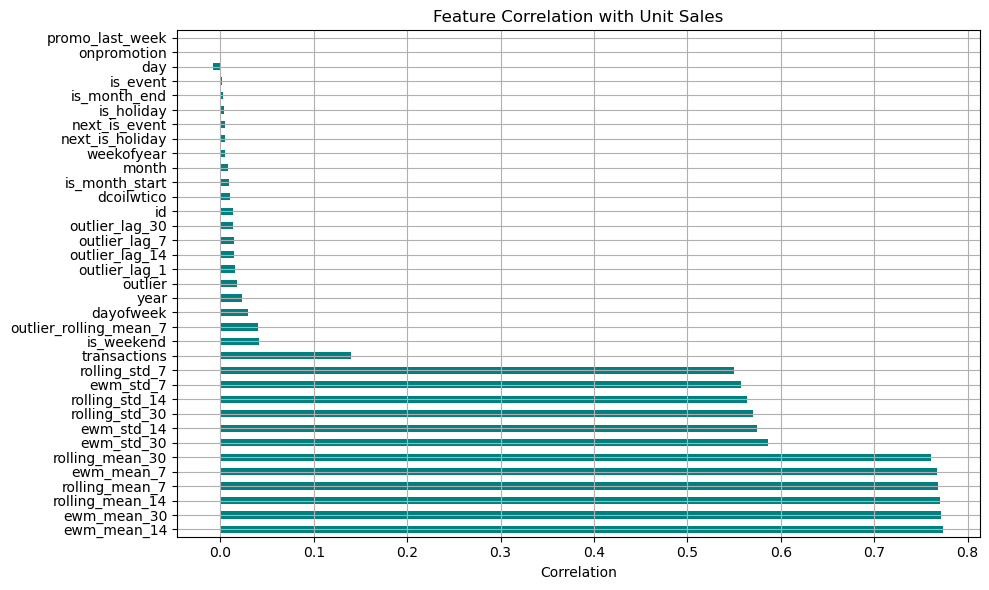

In [11]:
# Define columns we don't want to include in correlation analysis
excluded_columns = ['date', 'store_nbr', 'item_nbr', 'unit_sales']
correlation_columns = [col for col in df_train.columns if col not in excluded_columns]

correlation = df_train[correlation_columns + ['unit_sales']].corr()['unit_sales'].drop('unit_sales')

# Plot feature correlations with unit sales
plt.figure(figsize=(10, 6))  # Set the size of the plot
correlation.sort_values(ascending=False).plot.barh(color='teal')  # Horizontal bar chart
plt.title("Feature Correlation with Unit Sales")  # Title
plt.xlabel("Correlation")  # X-axis label
plt.grid(True)  # Show grid
plt.tight_layout()  # Adjust layout
plt.show()  # Display the plot

## Train and Test spilt

In [12]:
split_date = '2014-01-01'
train = df_train[df_train['date'] < split_date]
test = df_train[df_train['date'] >= split_date]

# Filter columns with more than 10% correlation with 'unit_sales' and add necessary columns for the model
high_corr_columns = correlation[correlation.abs() > 0.1].index.tolist()
columns = high_corr_columns + ['date', 'store_nbr', 'item_nbr', 'unit_sales']

# Filter train and test datasets for the selected columns
train_filtered = train[columns]
test_filtered = test[columns]



## Feature & Target Separation

In [16]:
# Creating X-train,  X_test,  by dropping 'date',  and'unit_sales'
X_train = train_filtered.drop(['date', 'unit_sales'], axis=1)
X_test = test_filtered.drop(['date', 'unit_sales'], axis=1)

y_train = train['unit_sales']
y_test = test['unit_sales']

In [17]:
# Feature Scaling ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##  Naive Model (XGBoost)

In [18]:
# Initialize the XGBoost regressor (default parameters)
xgboost_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100, # no of trees
    max_depth=5, # level of each trees
    learning_rate=0.1, # step size shrinkage
    enable_categorical=True
)

# Train the XGBoost model
xgboost_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

### Evaluation of Baseline Model

In [19]:
# Make predictions on the test set
y_pred = xgboost_model.predict(X_test_scaled)

# Evaluate the model
print("MSE:", mean_squared_error(y_true=y_test, y_pred=y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))
print("R2:", r2_score(y_true=y_test, y_pred=y_pred))

MSE: 26.36152310674439
RMSE: 5.134347388592283
MAPE: 1634074783148074.5
R2: 0.6502089819825113


## Plot Naive Predictions vs. Actual

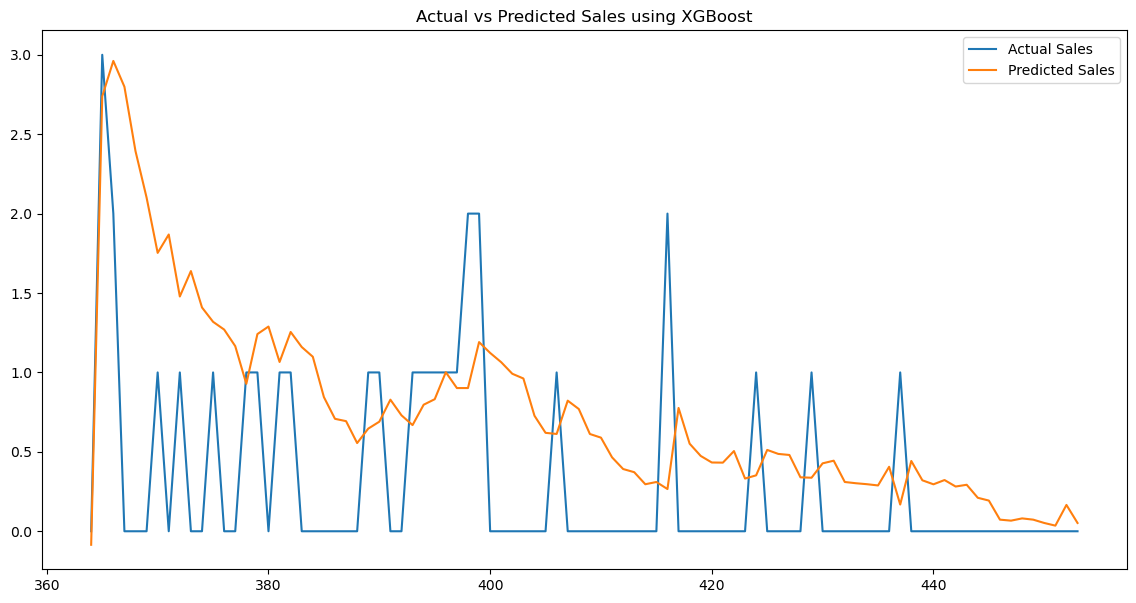

In [20]:
i =90# number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

In [ ]:
The Naive model gives an RMSE of 6.28, which sets a baseline for performance. While it is simple and interpretable, it does not capture any patterns or relationships in the data. Therefore, we proceed to train more sophisticated models like XGBoost to potentially improve prediction accuracy. If XGBoost achieves a lower RMSE, it will demonstrate added predictive value over this naive approach.

## Hyperparameter Tuning

We used XGBoost with RandomizedSearchCV to automatically find the best hyperparameters for forecasting sales.
This improves model accuracy by tuning parameters like learning rate, tree depth, and sample ratios.

In [21]:
# Initializing the model
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Define the parameter grid, trying 3 values for each parameter
param_grid = {
    'eta': [0.01, 0.1, 0.3], #learning rate (small = slower but better learning)
    'max_depth': [3, 5, 7], #how deep each decision tree is
    'subsample': [0.7, 0.8, 1.0], #subsample: what fraction of training rows to use
    'colsample_bytree': [0.7, 0.8, 1.0], #colsample_bytree: what fraction of columns (features) to use
    'n_estimators': [100, 200, 300] #how many trees to use
}

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=xgboost_model,
                                   param_distributions=param_grid,
                                   cv=tscv,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error' # this is the MSE metric
                                  )

# Fit the model and search for the best hyperparameters
random_search.fit(X_train_scaled, y_train)

# Get best hyperparameters
best_params = random_search.best_params_
print("Best Parameters for XGBoost:", best_params)


Best Parameters for XGBoost: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 5, 'eta': 0.01, 'colsample_bytree': 1.0}


In [22]:
best_model = random_search.best_estimator_

### Evaluation with best model parameter

In [23]:
# Make predictions on the test set
y_pred = best_model.predict(X_test_scaled)

# Evaluate the model
print("MSE:", mean_squared_error(y_true=y_test, y_pred=y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
print("MAPE:", mean_absolute_percentage_error(y_true=y_test, y_pred=y_pred))
print("R2:", r2_score(y_true=y_test, y_pred=y_pred))

MSE: 27.32028122464722
RMSE: 5.226880639984734
MAPE: 2062314406222504.0
R2: 0.6374872216830102


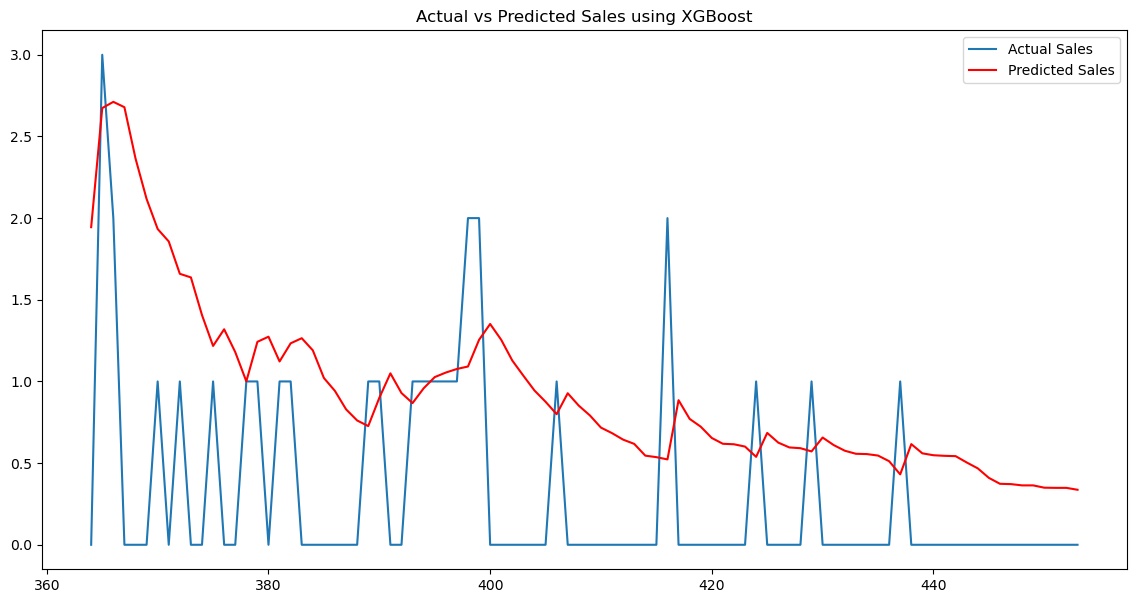

In [24]:
i =90 # number of days to plot
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[:i], y_test.values[:i], label='Actual Sales')
plt.plot(y_test.index[:i], y_pred[:i], label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

# Pickle the best model

In [25]:
import pickle

# Save a model
with open('Data/best_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Load a model
#with open('model.pkl', 'rb') as file:
#    loaded_model = pickle.load(file)